In [1]:
#import libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import time

from numpy import nan
from numpy import inf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif,f_classif,chi2

#  Data Analysis

In [2]:
#read thw data
data= pd.read_csv("Static_dataset.csv")

In [3]:
#show first five row
data.head()

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,56:19.8,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
1,07:23.9,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
2,23:15.1,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,0
3,04:51.9,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
4,12:44.0,15,9,0,11,0,2.929439,4,3,5,4.333333,local,local,15,1,1


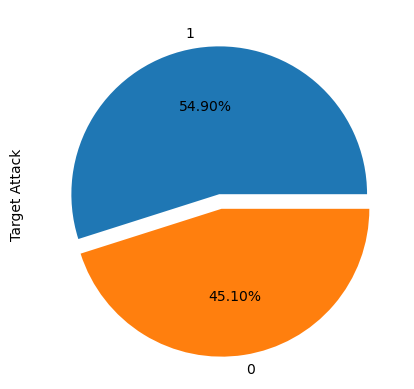

In [4]:
#show the target attack coulmn as pie plot
data['Target Attack'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.2f%%');

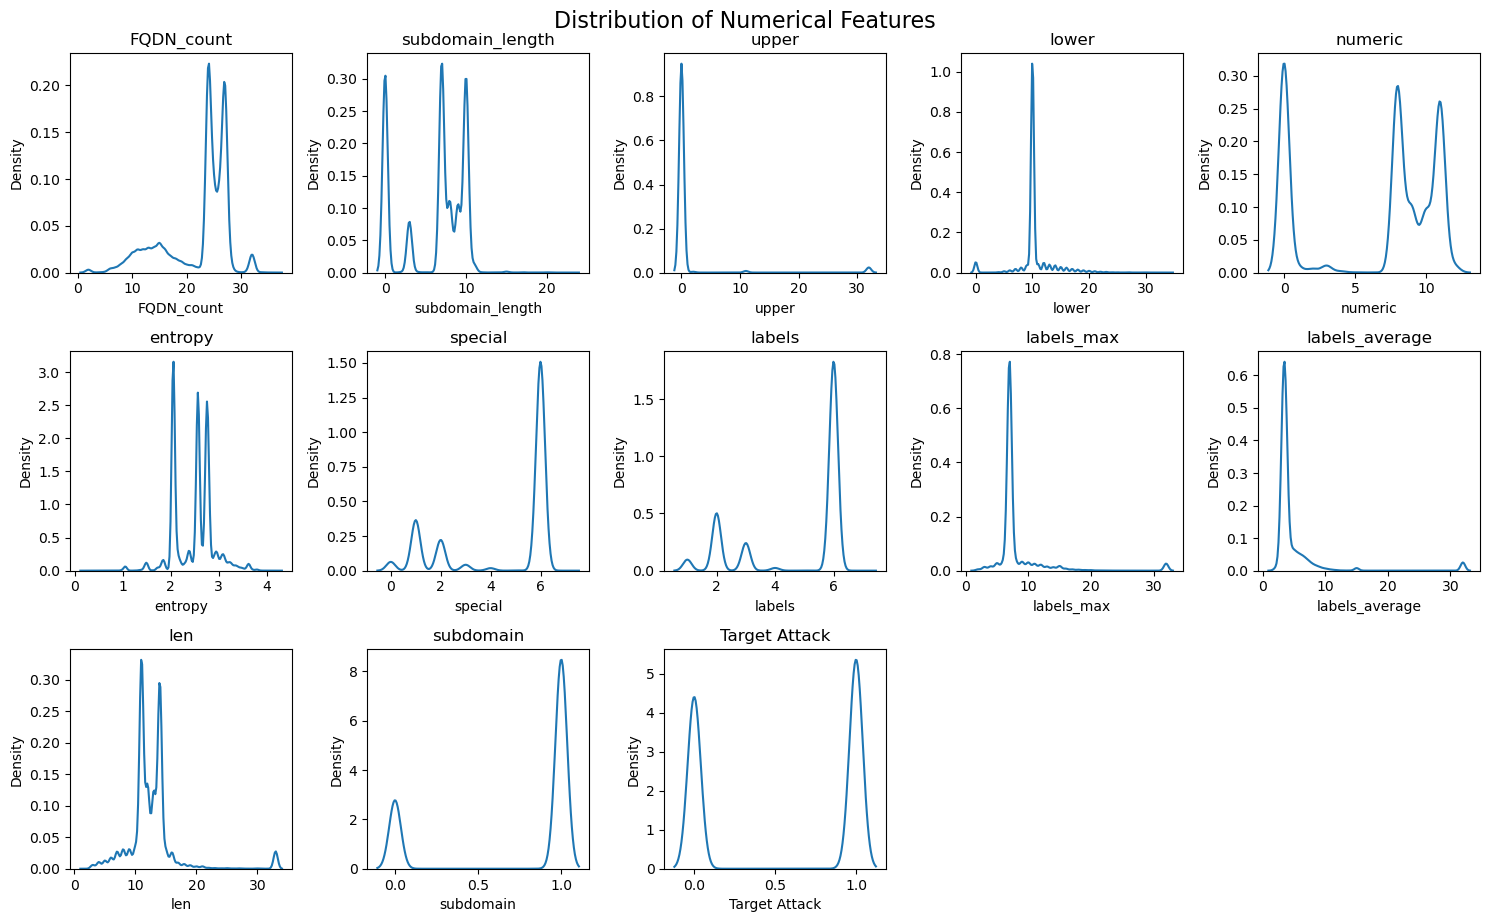

In [5]:
#show Distribution of Numerical Features for all coulmns
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()
plots_num = len(numerical_columns)
rows_num = 5
cols_num = 5
plt.figure(figsize=(15, 15))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(rows_num, cols_num, i)
    sns.kdeplot(data[column]) 
    plt.title(column)
plt.suptitle('Distribution of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

# Feature engineering and data cleaning

In [6]:
#show data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268074 entries, 0 to 268073
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         268074 non-null  object 
 1   FQDN_count        268074 non-null  int64  
 2   subdomain_length  268074 non-null  int64  
 3   upper             268074 non-null  int64  
 4   lower             268074 non-null  int64  
 5   numeric           268074 non-null  int64  
 6   entropy           268074 non-null  float64
 7   special           268074 non-null  int64  
 8   labels            268074 non-null  int64  
 9   labels_max        268074 non-null  int64  
 10  labels_average    268074 non-null  float64
 11  longest_word      268066 non-null  object 
 12  sld               268074 non-null  object 
 13  len               268074 non-null  int64  
 14  subdomain         268074 non-null  int64  
 15  Target Attack     268074 non-null  int64  
dtypes: float64(2), int64

In [7]:
#drop null values
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268066 entries, 0 to 268073
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         268066 non-null  object 
 1   FQDN_count        268066 non-null  int64  
 2   subdomain_length  268066 non-null  int64  
 3   upper             268066 non-null  int64  
 4   lower             268066 non-null  int64  
 5   numeric           268066 non-null  int64  
 6   entropy           268066 non-null  float64
 7   special           268066 non-null  int64  
 8   labels            268066 non-null  int64  
 9   labels_max        268066 non-null  int64  
 10  labels_average    268066 non-null  float64
 11  longest_word      268066 non-null  object 
 12  sld               268066 non-null  object 
 13  len               268066 non-null  int64  
 14  subdomain         268066 non-null  int64  
 15  Target Attack     268066 non-null  int64  
dtypes: float64(2), int64

In [8]:
# Calculate the mode of the "sld" and "longest_word" columns and store the result as an integer
sld_mode_v=int(data["sld"].mode()[0])
longest_word_mode_v=int(data["longest_word"].mode()[0])

In [9]:
#Replace all words in columns with the calculated mode value
data['longest_word'] = data['longest_word'].replace(r'(([a-z]+)|([A-Z]+))',sld_mode_v, regex=True)
data['longest_word']= data['longest_word'] .astype('int')
data['sld'] = data['sld'].replace(r'(([a-z]+)|([A-Z]+|(0-1)))',longest_word_mode_v, regex=True)
data['sld']=data['sld'] .astype('int')

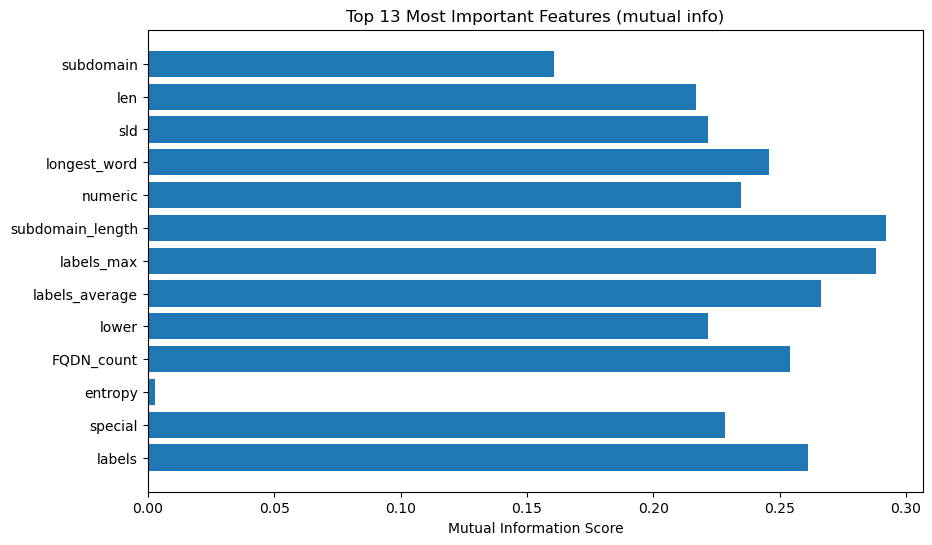

In [10]:
#feature selection using Mutual Information
X = data.drop(columns=['Target Attack',"timestamp"])
y = data['Target Attack']
k_best = SelectKBest(mutual_info_classif, k='all')
k_best.fit(X, y)
feature_scores = k_best.scores_
selected_feature_names = X.columns[k_best.get_support()]
sorted_feature_names = [x for _, x in sorted(zip(feature_scores, selected_feature_names), reverse=True)]
top_feature_names = sorted_feature_names[:-1]
top_feature_scores = feature_scores[k_best.get_support()][:-1]
plt.figure(figsize=(10, 6))
plt.barh(top_feature_names,top_feature_scores )
plt.xlabel('Mutual Information Score')
plt.title('Top {} Most Important Features (mutual info)'.format(13))
plt.gca()
plt.show()

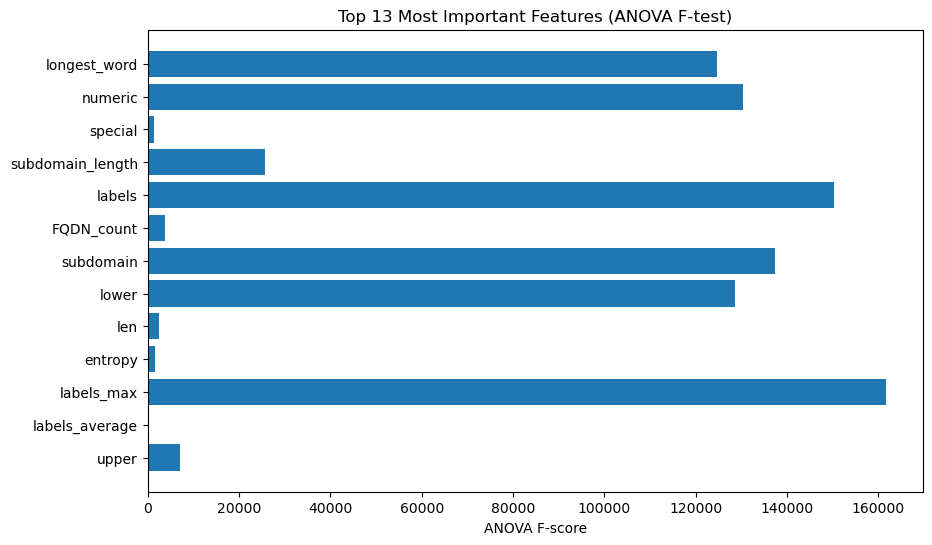

In [11]:
#feature selection using Anova
X = data.drop(columns=['Target Attack',"timestamp"])
y = data['Target Attack']
k_best = SelectKBest(f_classif, k='all')
k_best.fit(X, y)
f_scores = k_best.scores_
selected_feature_names = X.columns[k_best.get_support()]
sorted_feature_names = [x for _, x in sorted(zip(f_scores, selected_feature_names), reverse=True)]
num_features_to_plot = 13
top_feature_names = sorted_feature_names[:num_features_to_plot]
top_f_scores = f_scores[k_best.get_support()][:num_features_to_plot]
plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_f_scores)
plt.xlabel('ANOVA F-score')
plt.title('Top {} Most Important Features (ANOVA F-test)'.format(num_features_to_plot))
plt.gca().invert_yaxis()
plt.show()

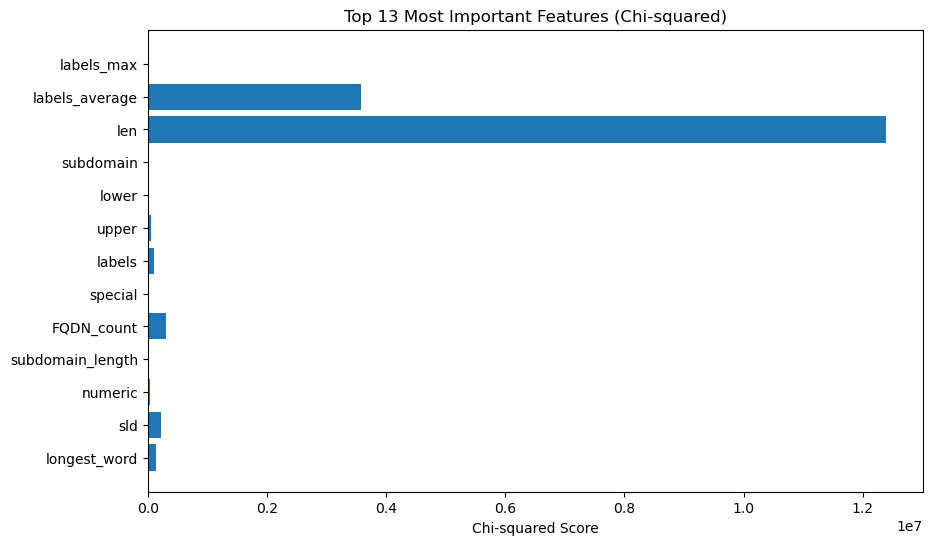

In [12]:
#feature selection using Chi-squared
X = data.drop(columns=['Target Attack',"timestamp"])
y = data['Target Attack']
k_best = SelectKBest(chi2, k='all')
k_best.fit(X, y)
chi2_scores = k_best.scores_
selected_feature_names = X.columns[k_best.get_support()]
sorted_feature_names = [x for _, x in sorted(zip(chi2_scores, selected_feature_names), reverse=True)]
num_features_to_plot = 13
top_feature_names = sorted_feature_names[:num_features_to_plot]
top_chi2_scores = chi2_scores[k_best.get_support()][:num_features_to_plot]
plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_chi2_scores)
plt.xlabel('Chi-squared Score')
plt.title('Top {} Most Important Features (Chi-squared)'.format(num_features_to_plot))
plt.gca()
plt.show()

In [13]:
#select feature function that select best k for model and data, we use it in next function
def select_feature(X_train, y_train, X_test, y_test, FSM, model):
  fs = FSM
  fs.fit(X_train, y_train)
  X_train_new = fs.transform(X_train)
  X_test_new = fs.transform(X_test) 
  model.fit(X_train_new, y_train)
  y_pred = model.predict(X_test_new)
  acc = accuracy_score(y_test, y_pred) * 100
  return acc

#select feature and plot function that select best k for model and data and plot number of features vs accuracies
def select_feature_and_plot(X_train, y_train, X_test, y_test, feature_selection, model, Title ):
    acc_dict = {}
    for nf in range(1, 13):
        fsm = SelectKBest(feature_selection, k=nf)
        acc = select_feature(X_train, y_train, X_test, y_test, fsm, model)
        acc_dict[nf] = acc

    plt.plot(*zip(*sorted(acc_dict.items())))
    Title = "Feature Selection with " + Title 
    plt.title(Title, fontsize=16)
    plt.xlabel("Number of Features", fontsize=16)
    plt.ylabel("Accuracy (%)", fontsize=16)

    max_acc = max(acc_dict.values())
    best_n_features = max(acc_dict, key=acc_dict.get)
    print("Maximum accuracy:", max_acc)
    print("Best number of features:", best_n_features)
    plt.show()
    return best_n_features
    
#function to perform feature selection and model evaluation
def evaluate_feature_selection(X_train, X_val, y_train, y_val, feature_selection,model, k):
    k_best = SelectKBest(feature_selection, k=k)
    k_best.fit(X_train, y_train)
    selected_feature_names = X.columns[k_best.get_support()]
    X_train_selected = X_train[selected_feature_names]
    X_val_selected = X_val[selected_feature_names]
    lr_model.fit(X_train_selected, y_train)
    y_pred_val = lr_model.predict(X_val_selected)
    accuracy = accuracy_score(y_val, y_pred_val)
    return accuracy

In [14]:
#split the data
X = data.drop(columns=['Target Attack',"timestamp"])
y = data['Target Attack']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# LogisticRegression model

In [15]:
# Create a Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

Maximum accuracy: 82.17110171599104
Best number of features: 11


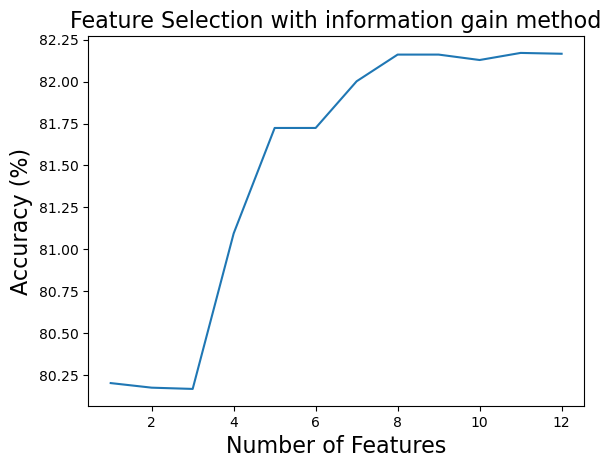

In [16]:
#use select_feature_and_plot for information gain method to select best feature num with max accuracy
logistic_best_k_mutual_info=select_feature_and_plot(X_train, y_train, X_test, y_test, mutual_info_classif, lr_model, "information gain method")

Maximum accuracy: 82.04675453867198
Best number of features: 11


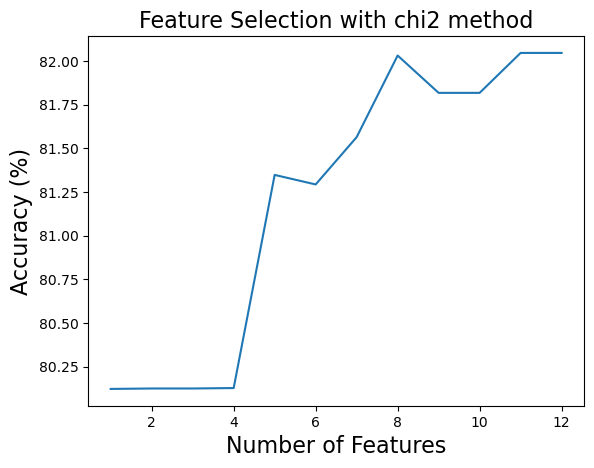

In [17]:
#use select_feature_and_plot for chi2 method to select best feature num with max accuracy
logistic_best_k_chi2=select_feature_and_plot(X_train, y_train, X_test, y_test, chi2, lr_model, "chi2 method")

Maximum accuracy: 82.14125839343447
Best number of features: 9


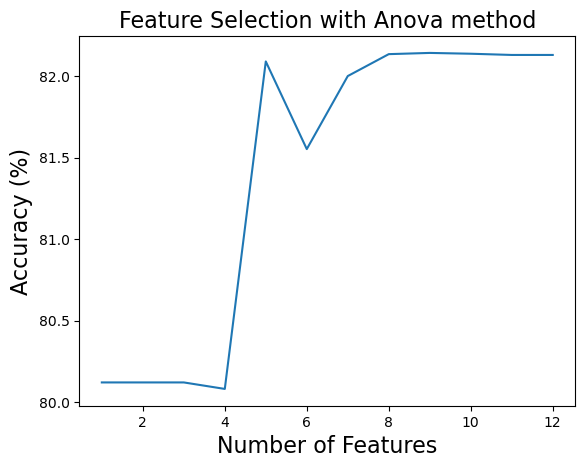

In [18]:
#use select_feature_and_plot for Anova method to select best feature num with max accuracy
logistic_best_k_anova=select_feature_and_plot(X_train, y_train, X_test, y_test, f_classif, lr_model, "Anova method")

In [19]:
#use evaluate_feature_selection function to perform feature selection and model evaluation for each feature selection method
logistic_mutual_info_accuracy = evaluate_feature_selection(X_train, X_val, y_train, y_val, mutual_info_classif, lr_model, logistic_best_k_mutual_info)
logistic_chi2_accuracy = evaluate_feature_selection(X_train, X_val, y_train, y_val, chi2, lr_model, logistic_best_k_chi2)
logistic_anova_accuracy = evaluate_feature_selection(X_train, X_val, y_train, y_val, f_classif, lr_model, logistic_best_k_anova)
print("Mutual Info Accuracy:", logistic_mutual_info_accuracy)
print("Chi-squared Accuracy:", logistic_chi2_accuracy)
print("ANOVA Accuracy:", logistic_anova_accuracy)

Mutual Info Accuracy: 0.827555334493907
Chi-squared Accuracy: 0.8258890823178314
ANOVA Accuracy: 0.8270828152200945


# RandomForestClassifier model

In [20]:
# Create a Logistic Regression model
rf_model = RandomForestClassifier(random_state=42)

Maximum accuracy: 82.38000497388708
Best number of features: 7


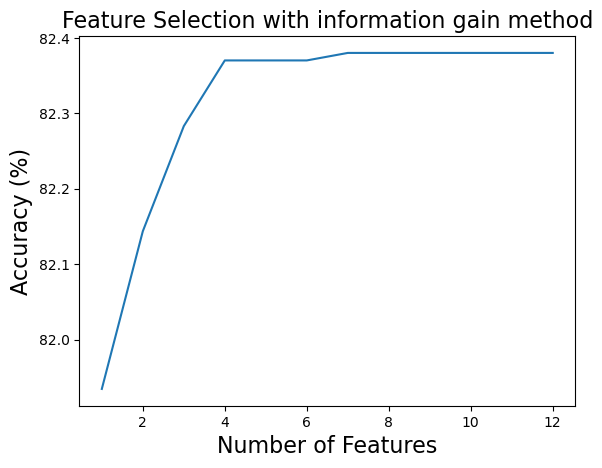

In [21]:
#use select_feature_and_plot for information gain method to select best feature num with max accuracy
Forest_best_k_mutual_info=select_feature_and_plot(X_train, y_train, X_test, y_test, mutual_info_classif, rf_model, "information gain method")

Maximum accuracy: 82.37751803034071
Best number of features: 11


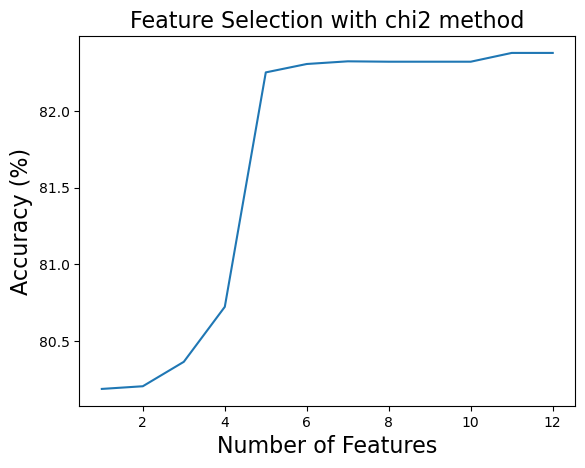

In [22]:
#use select_feature_and_plot for chi2 method to select best feature num with max accuracy
Forest_best_k_chi2=select_feature_and_plot(X_train, y_train, X_test, y_test, chi2, rf_model, "chi2 method")

Maximum accuracy: 82.38000497388708
Best number of features: 10


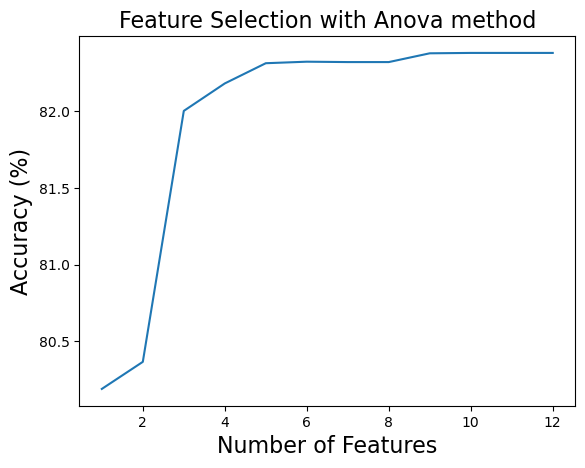

In [23]:
#use select_feature_and_plot for Anova method to select best feature num with max accuracy
Forest_best_k_anova=select_feature_and_plot(X_train, y_train, X_test, y_test, f_classif, rf_model, "Anova method")

In [24]:
#use evaluate_feature_selection function to perform feature selection and model evaluation for each feature selection method
Forest_mutual_info_accuracy = evaluate_feature_selection(X_train, X_val, y_train, y_val, mutual_info_classif, rf_model, Forest_best_k_mutual_info)
Forest_chi2_accuracy = evaluate_feature_selection(X_train, X_val, y_train, y_val, chi2, rf_model, Forest_best_k_chi2)
Forest_anova_accuracy = evaluate_feature_selection(X_train, X_val, y_train, y_val, f_classif, rf_model, Forest_best_k_anova)
print("Mutual Info Accuracy:", Forest_mutual_info_accuracy)
print("Chi-squared Accuracy:", Forest_chi2_accuracy)
print("ANOVA Accuracy:", Forest_anova_accuracy)

Mutual Info Accuracy: 0.825540910221338
Chi-squared Accuracy: 0.8258890823178314
ANOVA Accuracy: 0.8270330763491669


# Model evaluation

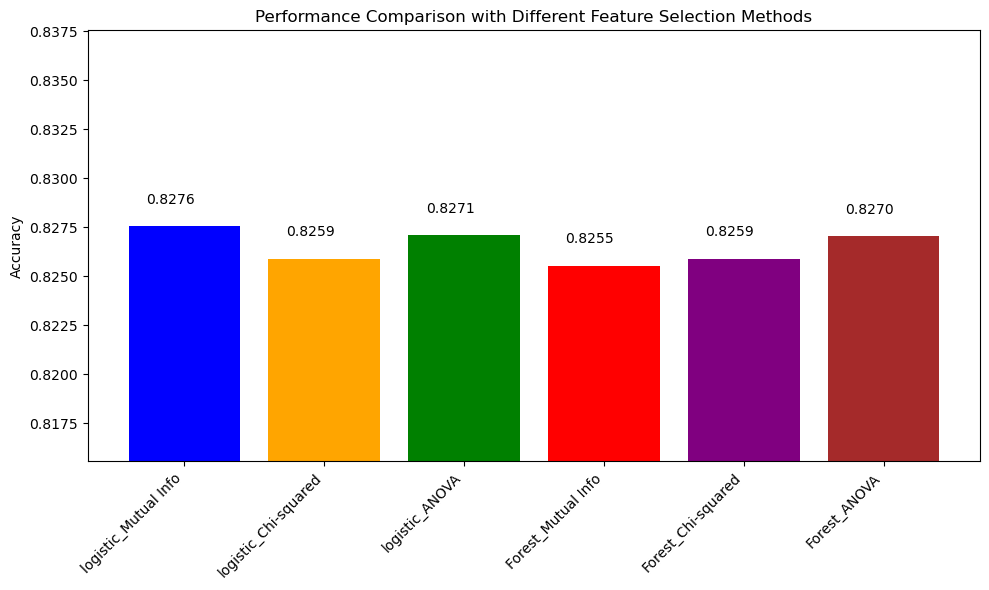

In [25]:
#plot accuracies for each two models (LR, RF) for each feature selection (Mutual Info, chi2, anova)
methods = ['logistic_Mutual Info', 'logistic_Chi-squared', 'logistic_ANOVA', 'Forest_Mutual Info', 'Forest_Chi-squared', 'Forest_ANOVA']
accuracies = [logistic_mutual_info_accuracy, logistic_chi2_accuracy, logistic_anova_accuracy, Forest_mutual_info_accuracy, Forest_chi2_accuracy, Forest_anova_accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(methods)), accuracies, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.ylabel('Accuracy')
plt.title('Performance Comparison with Different Feature Selection Methods')
plt.ylim([min(accuracies) - 0.01, max(accuracies) + 0.01])
plt.xticks(range(len(methods)), methods, rotation=45, ha='right')
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.001, f'{acc:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

the best model is logistic regression and feature selection is Mutual Info

In [26]:
#make GridSearch for the best model (logistic regression with Mutual Info) to find the best parameters
k_best = SelectKBest(mutual_info_classif, k=logistic_best_k_mutual_info)
k_best.fit(X, y)
feature_scores = k_best.scores_
selected_feature_names = X.columns[k_best.get_support()]
X_train_mutual_info=X_train[selected_feature_names]
pipeline = Pipeline([('classifier', LogisticRegression(max_iter=1000))])
param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [ 0.01, 0.1, 1, 10, 100]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_mutual_info, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Accuracy Score:", best_score)

C:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\anaconda\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\anaconda\lib\site-packages\skl

Best Parameters: {'classifier__C': 1, 'classifier__penalty': 'l2'}
Best Accuracy Score: 0.8235080962027432


In [39]:
#make pipeline for the best model with the best parameters 
feature_selection = SelectKBest(mutual_info_classif, k=logistic_best_k_mutual_info)
lr_classifier = LogisticRegression(max_iter=1000,C=1, penalty = 'l2')
pipeline = Pipeline([
    ('feature_selection', feature_selection),
    ('classifier', lr_classifier)
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_selection',
                 SelectKBest(k=11,
                             score_func=<function mutual_info_classif at 0x0000021310B0FAF0>)),
                ('classifier', LogisticRegression(C=1, max_iter=1000))])

In [40]:
#load pickle to use it in the dynamic model
import pickle
model_filename = 'mutual_info_lr_model.pkl'
pickle.dump(pipeline, open(model_filename, 'wb'))
xx=pickle.load(open('mutual_info_lr_model.pkl', 'rb'))